In [85]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Fri Nov 16 2018 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.3
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [44]:
# %matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
EXTRA = ['age', 'sex', 'sc_bef', 'sc_aft']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)

Opening raw data file /home/miroslav/Source/thesis_project/data/processed/1a.fif...
This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-44-a857d1235d28>:29: RuntimeWarning: This filename (/home/miroslav/Source/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [202]:
meta_df['SEX'] = meta_df['SEX'].astype('category')
print("Women: %s " % len(meta_df['SEX'][meta_df['SEX']==0]))
print("Men: %s " % len(meta_df['SEX'][meta_df['SEX']==1]))
print("Age: \n%s" % meta_df['AGE'].describe())
print('250 Hz: %s \t 1000 Hz: %s' % (len(meta_df[meta_df['freq']==250]),len(meta_df[meta_df['freq']==1000])))

Women: 104 
Men: 29 
Age: 
count    133.000000
mean      47.706767
std        9.577263
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: AGE, dtype: float64
250 Hz: 99 	 1000 Hz: 34


In [232]:
def prepare_dfs(col='lyap'):
    df = pd.read_pickle(os.path.join(LABELED_ROOT, col, f'training_{col}.pkl')) 
    df_bef = pd.read_pickle(os.path.join(LABELED_ROOT, col, f'{col}_bef.pkl'))
    df_aft = pd.read_pickle(os.path.join(LABELED_ROOT, col, f'{col}_aft.pkl'))
    return df, df_bef, df_aft
    
def prepare_resp_non(col='lyap'):
    df, df_bef, df_aft = prepare_dfs(col)
    return df[df['change'] >= df.quantile(0.66)['change']], df[df['change'] <= df.quantile(0.33)['change']]

df, df_bef, df_aft = prepare_dfs('lyap')
df_resp, df_non = prepare_resp_non('lyap')
df

FP1       FP2        F3        F4        C3        C4  \
patient trial                                                               
1       a      6.712546  7.864975  5.767693  6.400333  5.947713  5.434689   
        b      5.492759  6.610176  6.994197  5.251469  5.466008  5.797834   
3       a      7.608852  7.552476  7.543563  7.509622  7.839310  7.595212   
        b      7.170254  7.237360  7.406737  7.346416  6.957904  7.457414   
4       a      7.007709  7.119708  6.957571  7.113753  6.926749  7.104867   
        b      6.880050  6.979586  6.767042  6.992374  6.579624  6.957418   
5       a      6.904588  6.603393  6.303209  6.277043  6.261732  6.679320   
        b      6.636419  6.598773  6.193171  6.224208  5.992445  6.199761   
7       a      6.828138  6.552727  6.815736  6.760382  7.178805  7.085304   
        b      7.272204  7.201895  7.253179  7.003748  7.231619  7.382421   
9       a      6.795862  6.694299  6.874718  6.588140  6.603572  6.551102   
        b      6.868815  6.808268  6.607605  6.665253  6.645111  6.624893   
10      a      5.306790  5.425913  5.327632  5.453007  5.445322  6.285884   
        b      6.136419  5.905724  5.543049  5.818563  5.766838  6.006763   
11      a      6.577278  7.293087  6.454801  6.864052  6.640263  6.801292   
        b      6.410819  6.657494  5.179243  6.200679  4.689853  6.792823   
12      a      6.953163  5.545181  5.724785  6.152083  6.309962  5.893218   
        b      4.966443  5.244972  5.614386  7.058322  6.627366  6.529006   
14      a      6.152738  6.571066  5.806031  6.476984  6.188145  6.201588   
        b      6.839806  6.126994  6.300053  6.176549  5.944666  6.444605   
15      a      6.741335  5.837099  5.744261  5.581770  5.490892  5.974528   
        b      6.792634  5.285888  6.260918  5.349933  5.415582  5.506553   
16      a      6.385764  6.556119  6.791454  6.657483  7.349339  6.769954   
        b      6.580388  6.693168  6.874025  6.677320  7.118360  6.934844   
17      a      5.462632  5.872965  5.386126  5.453913  5.197555  6.093153   
        b      5.548471  5.455111  5.483230  5.633944  6.620388  6.307150   
18      a      4.576689  4.579895  4.358142  4.739874  4.757949  4.488038   
        b      4.180654  4.263125  4.565392  4.156536  4.493072  4.530826   
19      a      6.749157  6.772293  6.954918  7.031120  7.325379  7.168120   
        b      7.206045  7.158250  7.061182  6.731853  7.494038  7.345275   
...                 ...       ...       ...       ...       ...       ...   
115     a      6.656677  6.895471  6.722312  6.624168  6.943902  6.486644   
        b      6.711335  6.657406  6.725173  6.799888  6.594190  6.557144   
116     a      4.801365  4.229740  5.204138  5.546855  4.896968  5.430027   
        b      5.687944  4.721352  5.422229  5.400207  4.998972  4.993972   
117     a      6.105210  5.698372  6.672329  6.658724  5.800829  6.957082   
        b      5.857398  5.558349  6.668599  6.570080  6.482186  6.608964   
119     a      6.878782  6.799917  6.632019  6.657542  6.479385  6.516607   
        b      6.622362  7.085070  6.614023  6.444465  6.558354  6.424222   
121     a      6.952342  6.866591  7.119690  7.176010  6.396836  7.353890   
        b      4.513229  5.852568  6.432543  6.961210  6.769455  6.940018   
122     a      6.245629  7.476364  5.752476  7.627610  7.307943  7.149005   
        b      6.160556  7.499485  7.035194  7.561696  7.476952  7.440683   
123     a      6.924125  7.517435  7.319726  7.396358  6.941571  7.582041   
        b      5.979044  6.483726  5.331159  4.385703  5.516971  5.606412   
124     a      6.130119  6.314101  6.163036  6.206602  6.578738  6.498246   
        b      5.865241  6.091863  5.829719  5.795527  6.093987  6.250087   
126     a      5.872070  6.848522  6.161122  6.065067  5.655480  5.166402   
        b      6.508264  7.176598  6.806155  6.935746  6.617454  6.706685   
127     a      6.610233  6.828922  6.220191  6.895843  6.559609  5.749717   
        b      5

In [4]:
print('Men / Women: {} / {}'.format(len(df[df['sex']==1]), len(df[df['sex']==0])))
age_desc = df['age'].describe()
print('Age summary: \n{}'.format(age_desc))
m1_desc = df['sc_bef'].describe()
print('Measurement 1: \n{}'.format(m1_desc))
m2_desc = df['sc_aft'].describe()
print('Measurement 2: \n{}'.format(m2_desc))

Men / Women: 52 / 168
Age summary: 
count    220.000000
mean      48.063636
std        9.798217
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: age, dtype: float64
Measurement 1: 
count    220.000000
mean      27.654545
std        4.276807
min       17.000000
25%       25.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: sc_bef, dtype: float64
Measurement 2: 
count    220.000000
mean      16.972727
std        7.850730
min        2.000000
25%       11.000000
50%       17.000000
75%       23.000000
max       37.000000
Name: sc_aft, dtype: float64


# Before and after comparison plots

<IPython.core.display.Javascript object>


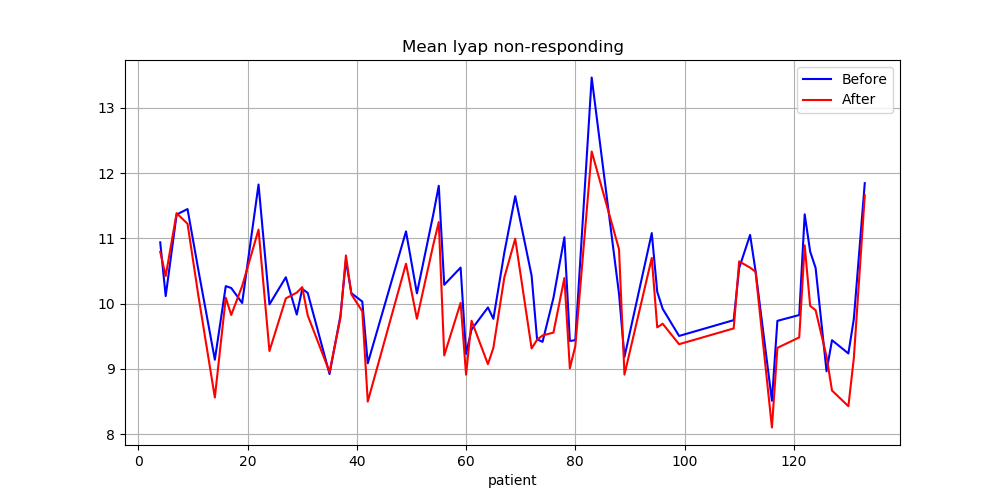

<IPython.core.display.Javascript object>


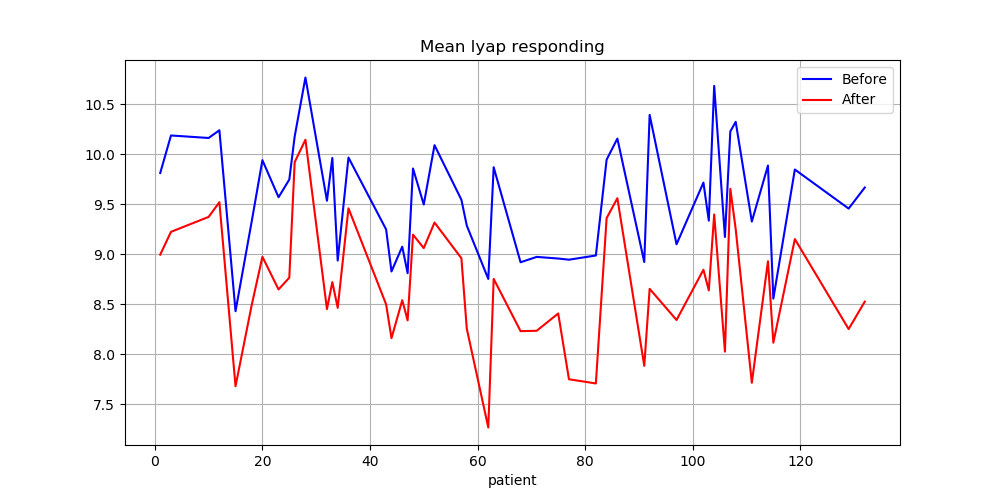

In [140]:
def plot_resp(df_bef, df_aft, m_name, resp):
    means_bef = df_bef[df_bef['label_r']==resp].mean(axis=1)
    means_aft = df_aft[df_aft['label_r']==resp].mean(axis=1)
    plt.figure(figsize=(10,5))
    ax1 = means_bef.plot(color='blue', grid=True, label='Before')
    ax2 = means_aft.plot(color='red', grid=True, label='After')
    plt.legend()
    m = 'responding' if resp else 'non-responding'
    plt.title(f'Mean {m_name} {m}')
    plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}_{m}.png'))
    plt.show()
    
def plot_measure(df_bef, df_aft, m_name):
    plot_resp(df_bef, df_aft, m_name, 0)
    plot_resp(df_bef, df_aft, m_name, 1)

# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
for col in ['lyap']:
    df, df_bef, df_aft = prepare_dfs(col)
    plot_measure(df_bef, df_aft, col)

<IPython.core.display.Javascript object>


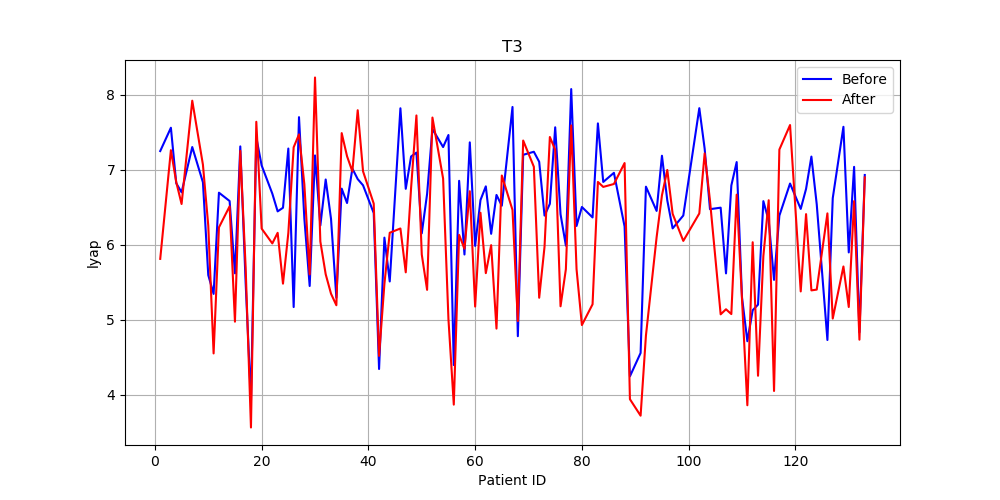

In [154]:
def plot_all(df_bef, df_aft, m_name, chan=None):
    if chan is not None:
        chan_bef = df_bef[chan]
        chan_aft = df_aft[chan]
    else:
        chan_bef = df_bef.mean(axis=1)
        chan_aft = df_aft.mean(axis=1)
        chan = 'Means'
    plt.figure(figsize=(10,5))
    ax1 = chan_bef.plot(color='blue', grid=True, label='Before')
    ax2 = chan_aft.plot(color='red', grid=True, label='After')
    plt.legend()
    plt.xlabel('Patient ID')
    plt.ylabel(f'{m_name}')
    plt.title(chan)
    # plt.savefig(os.path.join(VISUAL_ROOT, f'{m_name}.png'))
    plt.show()

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
# df_bef = df_bef[df_bef['label_r']==0]
# df_aft = df_aft[df_aft['label_r']==0]
plot_all(df_bef, df_aft, col, 'T3')

# Before and after K-S test

In [242]:
from scipy.stats import ks_2samp

def print_res(name, res, mean1='', mean2=''):
    if res.pvalue <= 0.02:
        m = '!!!'
    elif res.pvalue <= 0.05:
        m = '!!'
    elif res.pvalue < 0.08:
        m = '!'
    else:
        m = ''
    print('{}: \t {} \t {} \t {} \t {}'.format(name, res.pvalue, mean1, mean2, m))

def channel_wise_ks(df_bef, df_aft):
    print_res('Means', ks_2samp(df_bef[CHANNEL_NAMES].mean(axis=1), df_aft[CHANNEL_NAMES].mean(axis=1)), 
              df_bef[CHANNEL_NAMES].mean(axis=1).mean(), df_aft[CHANNEL_NAMES].mean(axis=1).mean())
    print_res('Stds', ks_2samp(df_bef[CHANNEL_NAMES].std(axis=1), df_aft[CHANNEL_NAMES].std(axis=1)), 
              df_bef[CHANNEL_NAMES].std(axis=1).mean(), df_aft[CHANNEL_NAMES].std(axis=1).mean())
    for col in CHANNEL_NAMES:
        print_res(col, ks_2samp(df_bef[col], df_aft[col]), df_bef[col].mean(), df_aft[col].mean())
        

# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
for col in ['lyap',]:
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    print('All')
    channel_wise_ks(df_bef, df_aft)
    print('\nNon-responding')
    channel_wise_ks(df_bef[df_bef['resp']==0], df_aft[df_aft['resp']==0])
    print('\nResponding')
    channel_wise_ks(df_bef[df_bef['resp']==1], df_aft[df_aft['resp']==1])
    print()

print('*** LOW / HIGH DEPRESSION SCORE ***')
# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
for col in ('lyap',):
    df, df_bef, df_aft = prepare_dfs(col)
    print(col.upper())
    low = df[df['sc'] <= df.quantile(0.33)['sc']]
    high = df[df['sc'] >= df.quantile(0.66)['sc']]
    channel_wise_ks(low, high)
    print()
    
print('*** RESPONDING / NON-RESPONDING - terciles ***')
# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst']:
for col in ('lyap',):
    df_resp, df_non = prepare_resp_non(col)
    print(col.upper())
    channel_wise_ks(df_resp.loc[(slice(None), 'a'), :] , df_non.loc[(slice(None), 'a'), :])
    print(len(df_resp), len(df_non))

LYAP
All
Means: 	 0.09437420582631745 	 6.637163274344296 	 6.462986774798418 	 
Stds: 	 0.1312293712733436 	 0.4467164758318463 	 0.5044627904505781 	 
FP1: 	 0.23952735572819522 	 6.373196357434315 	 6.207339125275434 	 
FP2: 	 0.5060304054051364 	 6.393074065962911 	 6.230008065101124 	 
F3: 	 0.09437420582631745 	 6.348971431672694 	 6.1225062923178415 	 
F4: 	 0.04611326353834362 	 6.438519909842441 	 6.112993963254866 	 !!
C3: 	 0.239527355728195 	 6.382761609763122 	 6.187845102650547 	 
C4: 	 0.17902368629316182 	 6.443042572409124 	 6.2282579767234525 	 
P3: 	 0.5060304054051377 	 6.802192645054152 	 6.69563183592506 	 
P4: 	 0.4033169318092446 	 6.825715930089158 	 6.710502853547353 	 
O1: 	 0.6185828173807626 	 6.950511048096436 	 6.878715739982936 	 
O2: 	 0.7336458901692725 	 6.928137780744359 	 6.814263785861236 	 
F7: 	 0.31412090452959734 	 6.615284104492087 	 6.459807853322872 	 
F8: 	 0.0665950626305342 	 6.652930260241501 	 6.388481028279685 	 !
T3: 	 0.0004143169171

# PCA

<IPython.core.display.Javascript object>


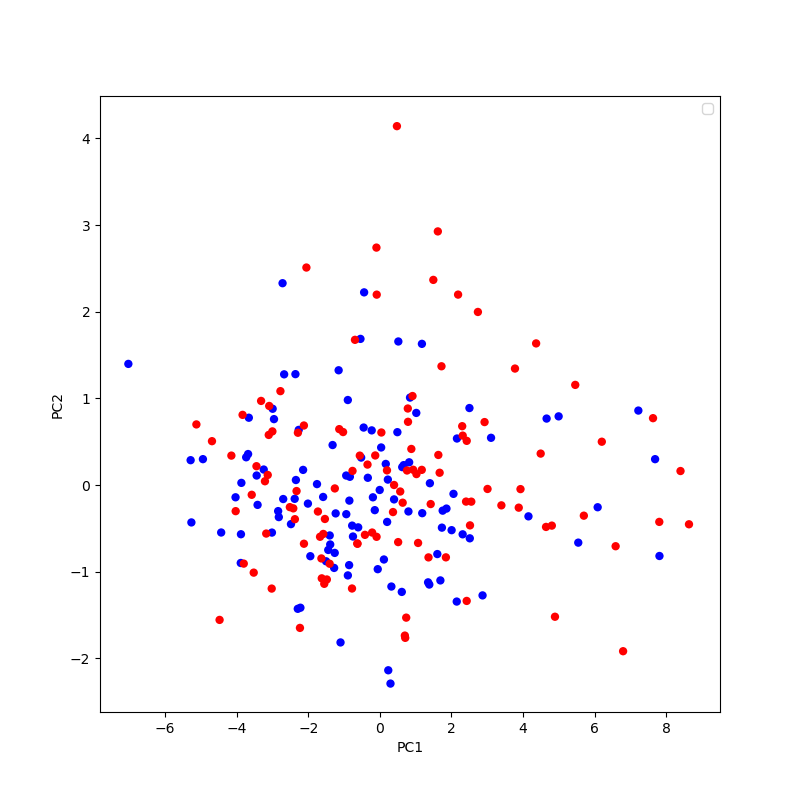

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [244]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

def plot_pca_2d(df_first, df_second=None, c1='blue', c2='red', title=""):
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(first[:,0], first[:,1], c=c1, cmap='Blues', edgecolors='', label='')
    if second is not None:
        plt.scatter(second[:,0], second[:,1], c=c2, cmap='Reds', edgecolors='', label='')
    # plt.title(title)
    plt.legend()
    # plt.colorbar()
    plt.show()

df, df_bef, df_aft = prepare_dfs('lyap')
df_resp, df_non = prepare_resp_non('lyap')
pca = decomposition.PCA(n_components=2)
pca.fit(df[CHANNEL_NAMES])

plot_pca_2d(df_bef, df_aft, title="Before / After")
# plot_pca_2d(df, None, c1=df['change'], title="Change in score")
# plot_pca_2d(df_bef, None, c1=df_bef['sc_bef'], title="")
# plot_pca_2d(df_aft, None, c1=df_aft['sc_aft'], title="")
# plot_pca_2d(df_aft[df_aft['sc_aft'] > 27], c1='red', title="")
# plot_pca_2d(df_bef[df_bef['sc_bef'] > 30], title="")
# plot_pca_2d(df[(df['sc']>30) & (df['sc']>30)], df[(df['sc'] < 20) & (df['sc'] < 20)], title="Depressed / Non-depressed")
# plot_pca_2d(df[df['sc'] <= 10], df[df['sc'] >= 30], title='Depressed / Not Depressed')
plot_pca_2d(df_resp.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'a'), :], title='Resp / Non')

<IPython.core.display.Javascript object>


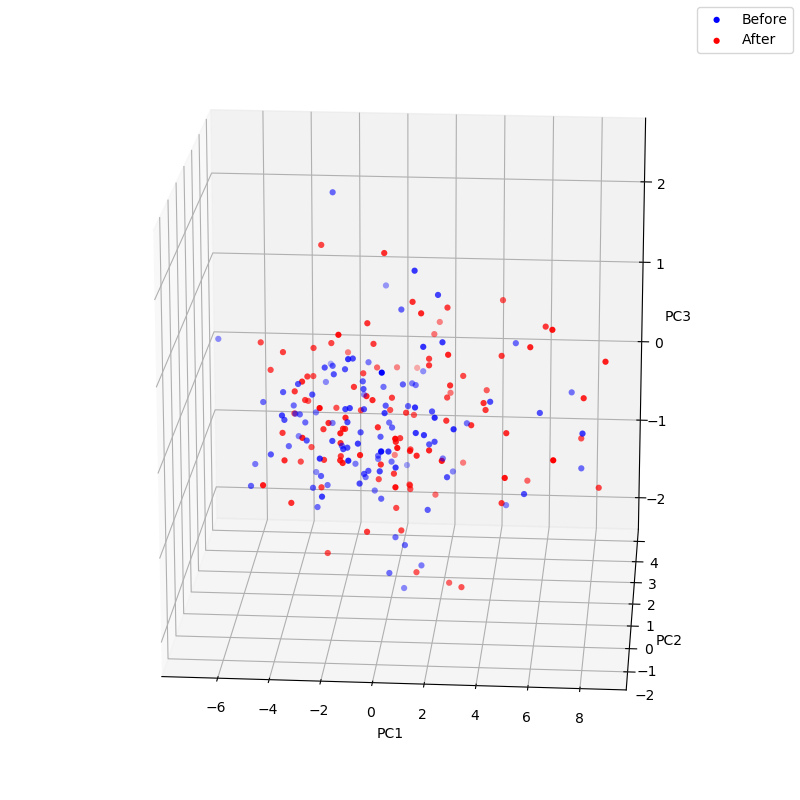

In [151]:
def plot_pca_3d(df_first, df_second=None, c1='blue', c2='red', title="", clus=False):
    pca = decomposition.PCA(n_components=3)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    if clus:
        clus_bef = df_first.iloc[(-4 < first[:,0]) & (first[:,0] < -2) & (first[:,1] < 1) & (0 < first[:,1]) & (abs(first[:,2]) < 1), :][EXTRA]
        clus_aft = df_second.iloc[(-4 < second[:,0]) & (second[:,0] < -2) & (second[:,1] < 1) & (0 < second[:,1]) & (abs(second[:,2]) < 1), :][EXTRA]
        overlap = clus_bef.join(clus_aft, how='inner', lsuffix='', rsuffix='_a')
        print(clus_bef)
        print(clus_aft)
        print(overlap.loc[:, ['age', 'sex', 'sc_bef', 'sc_aft']])
        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.scatter(first[:,0], first[:,1], first[:,2], c=c1, cmap='Blues', edgecolor='', label='Before')
    if second is not None:
        ax.scatter(second[:,0], second[:,1], second[:,2], c=c2, cmap='Reds', edgecolor='', label='After')
    # plt.title(title)
    plt.legend()
    plt.show()

df, df_bef, df_aft = prepare_dfs('lyap')

# plot_pca_3d(df_bef, df_aft, df_bef['age'], df_aft['age'])
plot_pca_3d(df_bef, df_aft, title="Before / After")
# plot_pca_3d(df[df['sex']==0], df[df['sex']==1], title="Men / Women") # Men corr cluster
# plot_pca_3d(df_bef, df_aft, df_bef['sc_bef'], df_aft['sc_aft'], title="Scores bef / aft")

<IPython.core.display.Javascript object>


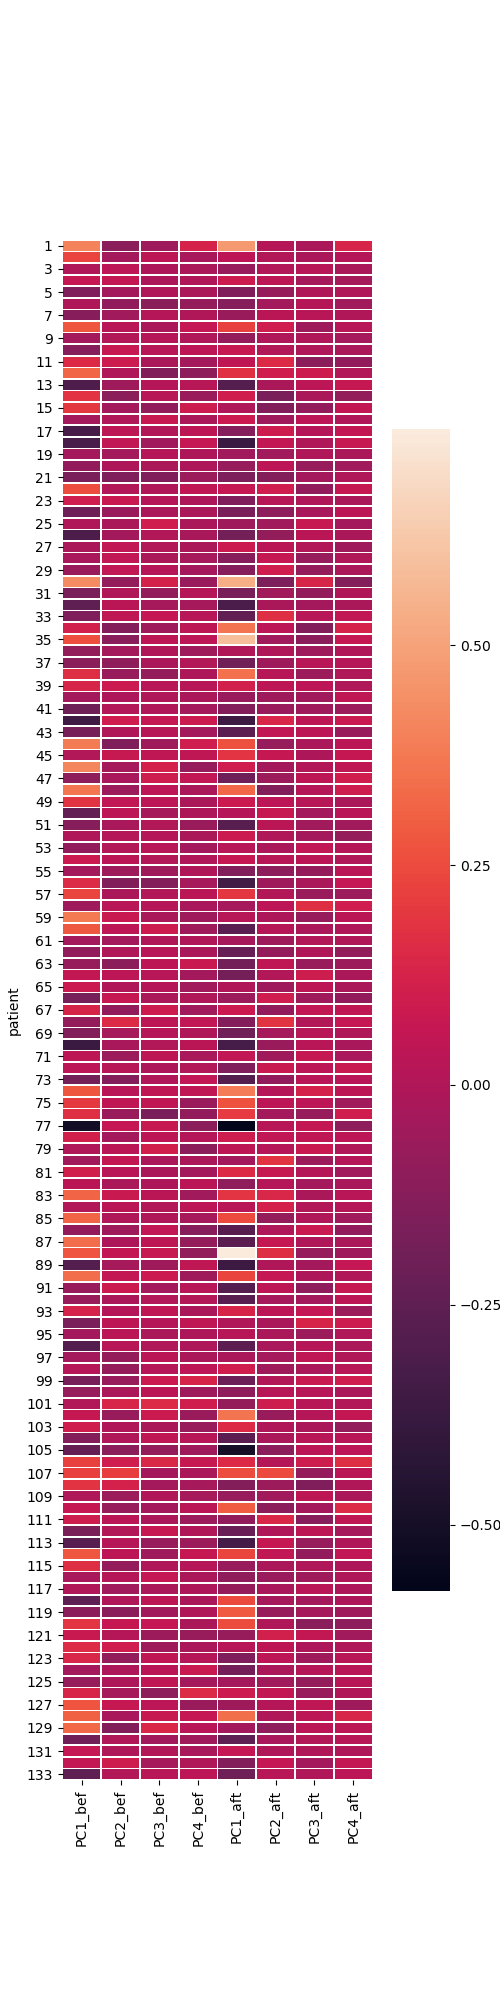

In [93]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

def plot_heatmap(df_bef=df_bef, df_aft=df_aft, n=3, title='All'):

    pca = decomposition.PCA(n_components=4)
    pca.fit(df[CHANNEL_NAMES])
    bef_proj_df = pd.DataFrame(pca.transform(df_bef[CHANNEL_NAMES]), index=df_bef.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    aft_proj_df = pd.DataFrame(pca.transform(df_aft[CHANNEL_NAMES]), index=df_aft.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])

    joined_df = bef_proj_df.join(aft_proj_df, lsuffix='_bef', rsuffix='_aft')

    plt.figure(figsize=(5, 20))
    ax = sns.heatmap(joined_df, linewidth=0.5)
    # plt.title(": ".join((measure, title)))
    plt.show()
    # plt.savefig(os.path.join(VISUAL_ROOT, "heatmaps", _".join((measure, title))+'.png'))

# for measure in ('lyap', 'corr', 'sampen'):
for measure in ('higu',):
    df, df_bef, df_aft = prepare_dfs(measure)
    plot_heatmap()
    # plot_heatmap(df_bef[df_bef['sex']==0], df_aft[df_aft['sex']==0], title='Women')
    # plot_heatmap(df_bef[df_bef['sex']==1], df_aft[df_aft['sex']==1], title='Men')
    # plot_heatmap(df_bef[df_bef['age']>50], df_aft[df_aft['age']>50], title='Age >= 50')
    # plot_heatmap(df_bef[df_bef['age']<=30], df_aft[df_aft['age']<=30], title='Age <= 30')
    # plot_heatmap(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1], title='Responding')
    # plot_heatmap(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0], title='Non-responding')
    # plot_heatmap(df_bef[df_bef['sc_bef']<25], df_aft[df_aft['sc_bef']<25], title='Score before < 25')
    # plot_heatmap(df_bef[df_bef['sc_bef']>=30], df_aft[df_aft['sc_bef']>=30], title='Score before >= 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']<25], df_aft[df_aft['sc_aft']<25], title='Score after < 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']>=30], df_aft[df_aft['sc_aft']>=30], title='Score after >= 25')
    

# Other ideas

<IPython.core.display.Javascript object>


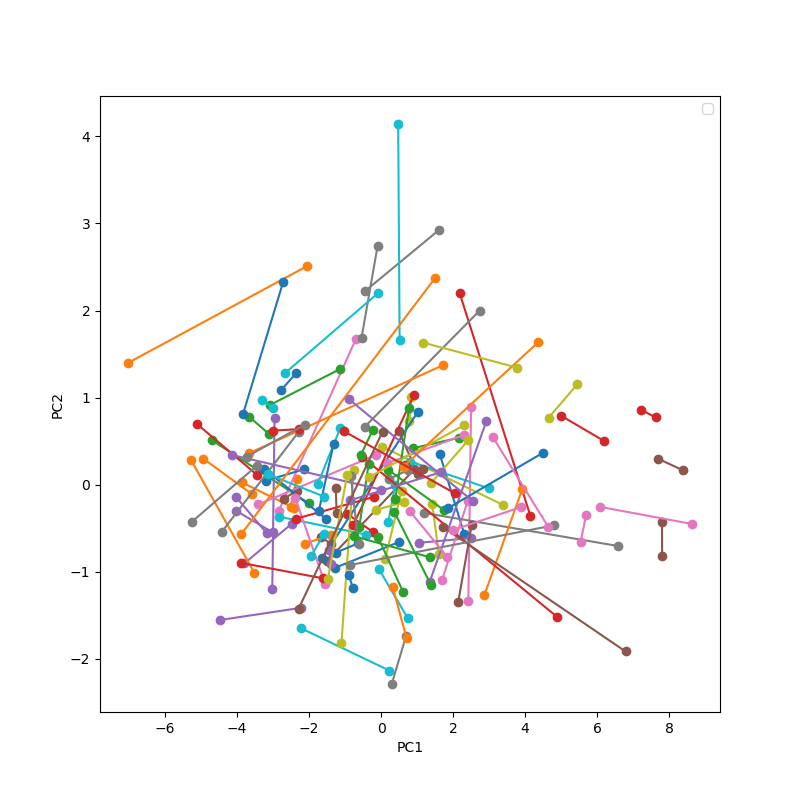

In [152]:
# Plot PCA, but same people with the same color

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def plot_pca_pairs_2d(df_first, df_second, title=""):
    pca = decomposition.PCA(n_components=2)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    for i in range(len(first)):
        xs = [first[i, 0], second[i, 0]]
        ys = [first[i, 1], second[i, 1]]
        plt.plot(xs, ys, 'o-')
        
    plt.title(title)
    plt.legend()
    plt.show()

df, df_bef, df_aft = prepare_dfs('lyap')

plot_pca_pairs_2d(df_bef, df_aft, title="")

In [153]:
# For each person, plot their distance between before / after
from math import sqrt

def filter_by_distance(df_first, df_second, n_components=3):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    dists = []
    for fr, sr in zip(first, second):
        dists.append(sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)])))
    perc = np.percentile(dists, 90)
    df = pd.DataFrame()
    for i, (fr, sr) in enumerate(zip(first, second)):
        dist = sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)]))
        if dist > perc:
            df = df.append(df_first.iloc[i, :]) 
    print(df.loc[:, ['label_r', 'age', 'sex', 'sc_bef', 'sc_aft', 'change']])
    

df, df_bef, df_aft = prepare_dfs('lyap')

filter_by_distance(df_bef, df_aft)

     label_r   age  sex  sc_bef  sc_aft    change
55       0.0  59.0  0.0    32.0    32.0  1.000000
56       0.0  48.0  0.0    31.0    27.0  1.148148
62       1.0  34.0  0.0    23.0    10.0  2.300000
64       0.0  53.0  0.0    26.0    26.0  1.000000
72       0.0  55.0  0.0    23.0    18.0  1.277778
83       0.0  63.0  1.0    41.0    34.0  1.205882
88       0.0  39.0  0.0    30.0    29.0  1.034483
92       1.0  61.0  0.0    29.0    10.0  2.900000
111      1.0  42.0  0.0    29.0     4.0  7.250000
123      0.0  54.0  1.0    24.0    25.0  0.960000
127      0.0  35.0  0.0    25.0    21.0  1.190476
